# Hierarchical Poisson Factorization
** *
This IPython notebook illustrates the usage of the [hpfrec](https://github.com/david-cortes/hpfrec) Python package for probabilistic Poisson matrix factorization on the [MillionSong TasteProfile dataset](https://labrosa.ee.columbia.edu/millionsong/tasteprofile) from EchoNest (48,000,000 entries from 1,000,000 users on 380,000 items). Unlike recommendations based on explicit user feedback such as movie ratings, recommending based on listening activity is harder as it is only an indirect measure of user preference, and doesn’t usually signal user dislikes.

HPF (Hierarchical Poisson Factorization) is a probabilistic model that tries to factorize the user-item interaction count matrix as the product of two lower dimensional matrices, just like regular factorization methods used with explicit feedback data, but taking this product as the parameter of a Poisson random variable (thus the model likelihood optimization is different from minimizing the sum of least squares of residuals). Additionally, the user-attribute and item-attribute matrices are given a Bayesian gamma prior, making them non-negative and adjusting for the user activity and song popularity levels.

Compared to competing methods such as BPR (Bayesian Personalized Ranking) or weighted-implicit ALS, it only requires iterating over the data for which an interaction was observed and not over data for which no interaction was observed (i.e. it doesn’t iterate over songs not played by the user), thus being more scalable, and at the same time producing better results when fit to counts data (in general).

For a similar package incorporating also item side information see [ctpfrec](https://github.com/david-cortes/ctpfrec/).

The implementation here is based on the paper _Scalable Recommendation with Hierarchical Poisson Factorization (P. Gopalan, 2015)_. For more details see the [online documentation](http://hpfrec.readthedocs.io/en/latest/).

**Small note: if the TOC here is not clickable or the math symbols don't show properly, try visualizing this same notebook from nbviewer following [this link](http://nbviewer.jupyter.org/github/david-cortes/hpfrec/blob/master/example/hpfrec_echonest.ipynb).**
** *
## Sections
* [1. Model description](#p1)
* [2. Loading the TasteProfile data](#p2)
* [3. Fitting the model](#p3)
* [4. Common-sense checks](#p4)
* [5. Making recommendations](#p5)
* [6. References](#p6)
** *
<a id="p1"></a>
## 1. Model Decription
The model consists in producing a non-negative matrix factorization of the User-Item activity matrix (a matrix where each entry corresponds to how many times each user interacted with each item) by the product of two lower-rank Matrices:
$$ Y \approx \Theta \beta^T $$

Which can be interpreted as latent factors for users and items.

These matrices are assumed to come from a generative process as follows:

* For each user $u$:
$\xi_u \sim Gamma(a', \frac{a'}{b'})$
    * For each latent factor $k$:
    $\Theta_{uk} \sim Gamma(a, \xi_u)$
* For each item $i$:
$\eta_i \sim Gamma(c', \frac{c'}{d'})$
    * For each latent factor $k$:
    $\beta_{ik} \sim Gamma(c, \eta_i)$


* For each user and item:
$y_{ui} \sim Poisson(\Theta_u^T \beta_i)$

_(Where the gamma distributions are defined in terms of shape and rate, rather than than shape and scale)._

**Note that this model can only make predictions for users and items that were present in the training data.**

The model is fit using mean-field approximation (a form of Bayesian variational inference) with coordinate-ascent (updating each parameter separetely until convergence). For more details see the paper in the references.
** *
<a id="p2"></a>
## 2. Loading the TasteProfile data

This example will fit the model to the TasteProfile data mentioned at the beginning, which consists of information about how many times did each user play a given song in an internet music listening service.

Reading the data:

In [1]:
import numpy as np, pandas as pd

playcounts = pd.read_table('train_triplets.txt',
                           sep='\t', header=None, names=['UserId','ItemId','Count'])

In [2]:
playcounts.shape

(48373586, 3)

Small sample of this data:

In [3]:
playcounts.head(5)

,UserId,ItemId,Count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


These are hashed IDs, but the EchoNest also provided the names of the songs and artists, along with genres for a small subsample of the songs, which are more human-readable than these IDs and help to assess recommendation quality:

In [4]:
song_info = pd.read_table('unique_tracks.txt', sep='<SEP>', engine='python',
             header=None, names=['TrackId','SongId','Artist','Song'])
genre_info = pd.read_table('msd-MAGD-genreAssignment.cls', sep='\t', engine='python',
             header=None, names=['TrackId','Genre'])
song_info = pd.merge(song_info, genre_info, on='TrackId', how='left')
song_info.head(5)

,TrackId,SongId,Artist,Song,Genre
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night,NaN
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan,NaN
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever,Electronic
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés,International
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens,NaN


Creating a train-test split for later:

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(playcounts, test_size=.2, random_state=1)
users_train = set(train.UserId)
items_train = set(train.ItemId)
test = test.loc[test.UserId.isin(users_train) & test.ItemId.isin(items_train)].reset_index(drop=True)
del users_train, items_train
del playcounts
test.shape

(9665366, 3)

** *
<a id="p3"></a>
## 3. Fitting the model
Fitting the model requires passing it the data as triplets (UserId, ItemId, Count), either in a pandas data frame or in a numpy array (with columns taken in that order) - the package does all the required internal reindexing:

In [6]:
%%time
from hpfrec import HPF

## Full call would be like this:
# recommender = HPF(k=50, a=0.3, a_prime=0.3, b_prime=1.0,
#                  c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
#                  stop_crit='train-llk', check_every=10, stop_thr=1e-3,
#                  maxiter=150, reindex=True, random_seed = 123,
#                  allow_inconsistent_math=False, verbose=True, full_llk=False,
#                  keep_data=True, save_folder=None, produce_dicts=True)

# For more information see the documentation:
# http://hpfrec.readthedocs.io/en/latest/


recommender = HPF(k=50, full_llk=False, random_seed=123,
                  check_every=10, maxiter=150, reindex=True,
                  allow_inconsistent_math=True, ncores=24,
                  save_folder='/home/david_cortes_rivera/hpfrec/parameters_dump/')
recommender.fit(train)

**********************************
Hierarchical Poisson Factorization
**********************************


Saving user and item mappings...

Number of users: 1019318
Number of items: 376768
Latent factors to use: 50

Initializing parameters...
Initializing optimization procedure...
Iteration 10 | train llk: -611632964 | train rmse: 6.9768
Iteration 20 | train llk: -557903203 | train rmse: 6.9407
Iteration 30 | train llk: -532560193 | train rmse: 6.9288
Iteration 40 | train llk: -521147249 | train rmse: 6.9187
Iteration 50 | train llk: -514927726 | train rmse: 6.9138
Iteration 60 | train llk: -511426959 | train rmse: 6.9104
Iteration 70 | train llk: -508619705 | train rmse: 6.9085
Iteration 80 | train llk: -506684404 | train rmse: 6.9060
Iteration 90 | train llk: -505680096 | train rmse: 6.9050
Iteration 100 | train llk: -504398187 | train rmse: 6.9037
Iteration 110 | train llk: -503916062 | train rmse: 6.9032


Optimization finished
Final log-likelihood: -503916062
Final RMSE: 6.9032
M

Note that I passed `allow_inconsistest_math=True`, so if you reproduce this notebook, even with the same random seed, you will end up with very slightly different results. For completely reproducible results use `allow_inconsistest_math=False`.

For better results, one can also add to the training data the artists as extra items with the sum of all songs from every artist played by each user, for example.

*Disclaimer: this notebook was run on a Google Cloud server with Skylake CPU using 24 cores. In a modern computer with 8 cores the same procedure takes at least 4 hours. It uses 13GB of RAM memory (including all the data loaded above).*

** *
<a id="p4"></a>
## 4. Common-sense checks


There are many different metrics to evaluate recommendation quality in implicit datasets, but all of them have their drawbacks. The idea of this notebook is to illustrate the package usage and not to introduce and compare evaluation metrics, so I will only perform some common sense checks on the test data.

For implementations of evaluation metrics for implicit recommendations see other packages such as [lightFM](https://github.com/lyst/lightfm).

As some common sense checks, the predictions should:
* Be higher for this non-zero hold-out sample than for random items.
* Produce a good discrimination between random items and those in the hold-out sample (very related to the first point).
* Be correlated with the playcounts in the hold-out sample.
* Follow an exponential distribution rather than a normal or some other symmetric distribution.

Here I'll check these four conditions:

In [7]:
test['Predicted'] = recommender.predict(user=test.UserId, item=test.ItemId)
test['RandomItem'] = np.random.choice(train.ItemId, size=test.shape[0])
test['PredictedRandom'] = recommender.predict(user=test.UserId, item=test.RandomItem)
print("Average prediction for combinations in test set: ", test.Predicted.mean())
print("Average prediction for random combinations: ", test.PredictedRandom.mean())

Average prediction for combinations in test set:  0.08565904
Average prediction for random combinations:  0.02818478


In [8]:
from sklearn.metrics import roc_auc_score

was_played = np.r_[np.ones(test.shape[0]), np.zeros(test.shape[0])]
score_model = np.r_[test.Predicted.values, test.PredictedRandom.values]
roc_auc_score(was_played, score_model)

0.7350906386411393

In [9]:
np.corrcoef(test.Count, test.Predicted)[0,1]

0.11768852679097562

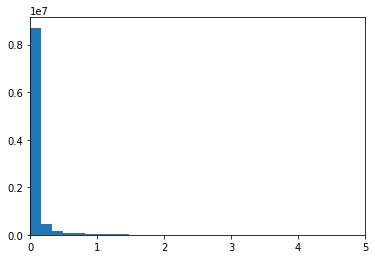

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(test.Predicted, bins=1000)
plt.xlim(0,5)
plt.show()

** *
<a id="p5"></a>
## 5. Making recommendations

The package provides a simple API for making predictions and Top-N recommended lists. These Top-N lists can be made among all items, or across some user-provided subset only, and you can choose to discard items with which the user had already interacted in the training set.

Here I will:
* Pick 3 random users with a reasonably long history of played songs.
* Check which songs they had played in the training data with which the model was fit.
* See which songs would the model recommend to them among those which they have not yet played.

Generating a random sample of users:

In [11]:
total_plays_by_user = train.groupby('UserId').agg({'Count':np.sum})
total_plays_by_user = total_plays_by_user[total_plays_by_user.Count > 1000]

np.random.seed(1)
sample_users = np.random.choice(total_plays_by_user.index, 3)
sample_users

array(['53cc3e95468819addbfcaa1256b460984c581be3',
       '135b8f915ae1a8849923ed77b3c568b842fcc3e3',
       '5639c710ef9f7eeab64e28ecdb1c2777a9bbf44c'], dtype=object)

Recommendation API:

In [12]:
%%time
recommender.topN(user = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e',
                 n=10, exclude_seen = True)

CPU times: user 412 ms, sys: 4 ms, total: 416 ms
Wall time: 45.8 ms


array(['SOEGIYH12A6D4FC0E3', 'SOWEHOM12A6BD4E09E', 'SOBFRNE12A6D4F7995',
       'SOBABRB12A6701DF4B', 'SOHALKJ12AB017FCC2', 'SOAXGDH12A8C13F8A1',
       'SOUJVIT12A8C1451C1', 'SOXKOIY12A8C13C1EA', 'SOUVTSM12AC468F6A7',
       'SOSPXWA12AB0181875'], dtype=object)

In order to examine the individual recommendations and playcounts, I'll take the artist and song names from the side info at the beginning:

In [13]:
train = pd.merge(train, song_info, left_on='ItemId', right_on='SongId')

### First user:

Top-played songs from this user:

In [14]:
train.loc[train.UserId==sample_users[0]]\
[['Artist','Song','Genre','Count']].sort_values('Count', ascending=False)\
.head(15)

,Artist,Song,Genre,Count
10782923,The Chordettes,Mr Sandman,NaN,44
30653682,be your own PET,Adventure,NaN,41
20297896,She & Him,Thieves,NaN,36
32590953,Clutch,Rock N Roll Outlaw (LP Version),Pop_Rock,33
8988743,Primus,Over The Falls,NaN,33
16884573,Tom Waits,I Don't Wanna Grow Up,Pop_Rock,32
28219786,Cake,She'll Come Back To Me,Pop_Rock,30
19270963,Tom Waits,Yesterday Is Here,Pop_Rock,30
39636272,The Browns featuring Jim Ed Brown,Scarlet Ribbons (For Her Hair),NaN,28
32236767,Tom Waits,You Can Never Hold Back Spring,Pop_Rock,27


Recommended for this user:

In [15]:
recommended_list = recommender.topN(sample_users[0], n=15)
song_info[['Artist', 'Song', 'Genre']]\
[song_info.SongId.isin(recommended_list)].drop_duplicates()

,Artist,Song,Genre
5998,Beastie Boys,The Maestro,Rap
37848,Datarock,True Stories,NaN
38414,Colossal,Brave The Elements,NaN
43314,Cake,Never There,Pop_Rock
159457,Jason Mraz,The Remedy (I Won't Worry) (New EQ'd LP Version),NaN
352523,Cass McCombs,Deseret,Pop_Rock
373834,Angels and Airwaves,The Gift,NaN
448596,Kollaa Kestää,Musti Sotakoira (2007 Digital Remaster),NaN
488566,Jason Mraz,You And I Both (LP Version),Pop_Rock
674513,Deadmau5,Ghosts 'n' Stuff (Original Instrumental Mix),NaN


### Second user:

Top-played songs from this user:

In [16]:
train.loc[train.UserId==sample_users[1]]\
[['Artist','Song','Genre','Count']].sort_values('Count', ascending=False)\
.head(10)

,Artist,Song,Genre,Count
7881646,Biffy Clyro,Many Of Horror,Pop_Rock,28
2551195,Biffy Clyro,God & Satan,Pop_Rock,24
1717356,Randy Crawford,Almaz,RnB,20
4623955,Three Drives,Greece 2000,Pop_Rock,20
3328333,Five Iron Frenzy,Canada,Pop_Rock,19
10741410,Biffy Clyro,Mountains,Pop_Rock,16
7451440,Pavement,Mercy:The Laundromat,Pop_Rock,16
11994,Florence + The Machine,Kiss With A Fist,NaN,14
39084173,Willie Rosario,Satin Lace,Latin,13
917301,Alliance Ethnik,Sincerité Et Jalousie,NaN,12


Recommended for this user:

In [17]:
recommended_list = recommender.topN(sample_users[1], n=10)
song_info[['Artist', 'Song','Genre']]\
[song_info.SongId.isin(recommended_list)].drop_duplicates()

,Artist,Song,Genre
151710,Florence + The Machine,Dog Days Are Over (Radio Edit),NaN
364862,Future Rock,Gears,Electronic
448841,Dwight Yoakam,You're The One,Country
452494,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Electronic
474953,Joe Nichols,Talk Me Out Of Tampa,Country
566672,Die Mooskirchner,Frisch und g'sund,Electronic
573462,Cradle Of Filth,Better To Reign In Hell,Pop_Rock
697821,Lynyrd Skynyrd,Sweet home Alabama,NaN
727100,The Verve,Lord I Guess I'll Never Know,Pop_Rock
921266,Cliff Richard & The Shadows,Nine Times Out Of Ten (1998 Digital Remaster),NaN


### Third user:

Top-played songs from this user:

In [18]:
train.loc[train.UserId==sample_users[2]]\
[['Artist','Song','Genre','Count']].sort_values('Count', ascending=False)\
.head(10)

,Artist,Song,Genre,Count
25079694,Alison Krauss,I Give You To His Heart,NaN,33
39409691,The Emotions,Blessed,RnB,17
34256734,The Emotions,Cause I Love You,NaN,16
39654206,The Emotions,Love Is Right On,NaN,15
33212256,The Emotions,So I Can Love You,NaN,15
38099409,The Emotions,Smile,NaN,15
21444022,Franco Battiato,Ruby Tuesday,Pop_Rock,12
1650223,The Crystals,He's A Rebel,NaN,11
39520735,Sister Sledge,We Are Family (Single Version),Pop_Rock,11
36723009,Bryan Adams,East Side Story,Pop_Rock,10


Recommended for this user:

In [19]:
recommended_list = recommender.topN(sample_users[2], n=10)
song_info[['Artist', 'Song','Genre']]\
[song_info.SongId.isin(recommended_list)].drop_duplicates()

,Artist,Song,Genre
80564,Captain Sensible,Wot,NaN
214584,The Casualties,Fight For Your Life,Pop_Rock
257680,Looptroop,Long Arm Of The Law,Rap
364862,Future Rock,Gears,Electronic
566672,Die Mooskirchner,Frisch und g'sund,Electronic
641933,DeGarmo & Key,When The Son Begins To Reign (Degarmo And Key ...,NaN
695466,Sheena Easton,Strut (1993 Digital Remaster),NaN
771510,Keith Sweat Featuring Athena Cage,Nobody (Featuring Athena Cage) (LP Version),NaN
797150,Bow Wow,Like You,NaN
866377,Warren Barfield,Love Is Not A Fight,Religious


** *
<a id="p6"></a>
## 6. References

* Gopalan, Prem, Jake M. Hofman, and David M. Blei. "Scalable Recommendation with Hierarchical Poisson Factorization." UAI. 2015.
* Gopalan, Prem, Jake M. Hofman, and David M. Blei. "Scalable recommendation with poisson factorization." arXiv preprint arXiv:1311.1704 (2013).